# 1. 构建语料库

In [1]:
sentences = [
    "Kage is Teacher", "Mazong is Boss", "Niuzong is Boss",
    "Xiaobing is Student", "Xiaoxue is Student"
]
words = " ".join(sentences).split()
word_list = list(set(words))
word_to_idx = {w: i for i, w in enumerate(word_list)}
idx_to_word = {i: w for i, w in enumerate(word_list)}
voc_size = len(word_list)
print(f"词汇表: {word_list}")
print(f"词汇到索引: {word_to_idx}")
print(f"索引到词汇: {idx_to_word}")
print(f"词汇表大小: {voc_size}")

词汇表: ['Mazong', 'Xiaoxue', 'Student', 'Xiaobing', 'Teacher', 'Boss', 'Niuzong', 'is', 'Kage']
词汇到索引: {'Mazong': 0, 'Xiaoxue': 1, 'Student': 2, 'Xiaobing': 3, 'Teacher': 4, 'Boss': 5, 'Niuzong': 6, 'is': 7, 'Kage': 8}
索引到词汇: {0: 'Mazong', 1: 'Xiaoxue', 2: 'Student', 3: 'Xiaobing', 4: 'Teacher', 5: 'Boss', 6: 'Niuzong', 7: 'is', 8: 'Kage'}
词汇表大小: 9


# 2. 生成 SkipGram 数据集

In [2]:
def create_skipgram_dataset(sentences, window_size=2):
    data = []
    for sentence in sentences:
        sentence = sentence.split()
        for idx, word in enumerate(sentence):
            for neighbor in sentence[max(idx - window_size, 0): min(idx + window_size, len(sentence))]:
                if neighbor != word:
                    data.append((neighbor, word))
    return data

In [3]:
skipgram_data = create_skipgram_dataset(sentences)
print(f"SkipGram 数据集: {skipgram_data[:3]}")

SkipGram 数据集: [('is', 'Kage'), ('Kage', 'is'), ('Teacher', 'is')]


# 3. 进行 OneHot 编码

In [4]:
import torch

def one_hot_encoding(word, word_to_idx):
    tensor = torch.zeros(len(word_to_idx))
    tensor[word_to_idx[word]] = 1
    return tensor


word_sample = "Teacher"
print(f"编码前单词: {word_sample}")
print(f"Onehot 编码: {one_hot_encoding(word_sample, word_to_idx)}")
print(
    f"SkipGram 数据样例: {[(one_hot_encoding(context, word_to_idx), word_to_idx[target]) for context, target in skipgram_data[:3]]}")

编码前单词: Teacher
Onehot 编码: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.])
SkipGram 数据样例: [(tensor([0., 0., 0., 0., 0., 0., 0., 1., 0.]), 8), (tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.]), 7), (tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.]), 7)]


# 4. 定义 SkipGram 模型

In [5]:
import torch.nn as nn

class SkipGram(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super().__init__()
        self.input_to_hidden = nn.Linear(voc_size, embedding_size, bias=False)
        self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias=False)

    def forward(self, X):
        hidden = self.input_to_hidden(X)
        output = self.hidden_to_output(hidden)
        return output


In [6]:
embedding_size = 2
skipgram_model = SkipGram(voc_size, embedding_size)
print(skipgram_model)

SkipGram(
  (input_to_hidden): Linear(in_features=9, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)


# 5. 训练 SkipGram 模型

In [7]:
import torch.optim as optim

learning_rate = 0.001
epochs = 1000
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate)
loss_values = []
for epoch in range(epochs):
    loss_sum = 0
    for context, target in skipgram_data:
        X = one_hot_encoding(target, word_to_idx).float().unsqueeze(0)
        y_true = torch.tensor([word_to_idx[context]], dtype=torch.long)
        y_pred = skipgram_model(X)
        loss = criterion(y_pred, y_true)
        loss_sum += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch:{epoch + 1}, Loss:{loss_sum / len(skipgram_data)}")
        loss_values.append(loss_sum / len(skipgram_data))




Epoch:100, Loss:2.1198925399780273
Epoch:200, Loss:2.0557241535186765
Epoch:300, Loss:1.9630549812316895
Epoch:400, Loss:1.8459221887588502
Epoch:500, Loss:1.7302299118041993
Epoch:600, Loss:1.6395027232170105
Epoch:700, Loss:1.574632568359375
Epoch:800, Loss:1.5287243282794953
Epoch:900, Loss:1.4957006162405013
Epoch:1000, Loss:1.471000988483429


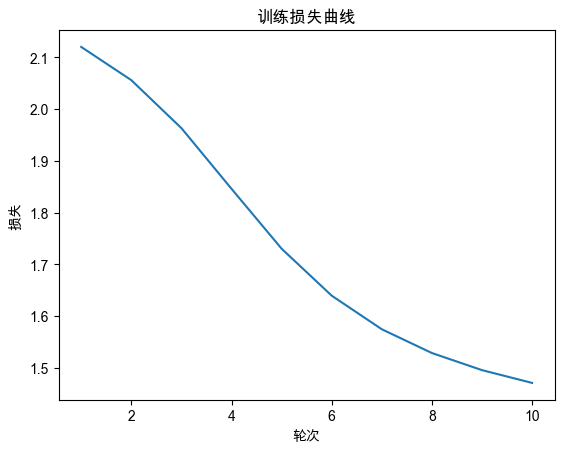

In [8]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = ["Arial Unicode MS"]
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False

plt.plot(range(1, epochs // 100 + 1), loss_values)
plt.title("训练损失曲线")
plt.xlabel("轮次")
plt.ylabel("损失")
plt.show()

# 6. 展示词向量

In [9]:
print("SkimGram Embedding")
for word, idx in word_to_idx.items():
    print(f"{word}: {skipgram_model.input_to_hidden.weight[:, idx].detach().numpy()}")

SkimGram Embedding
Mazong: [1.0966609  0.20320559]
Xiaoxue: [0.8413485  0.63397044]
Student: [0.7986277  0.12920831]
Xiaobing: [1.2187368 0.1632167]
Teacher: [0.6037588  0.31950766]
Boss: [0.20899303 1.3046933 ]
Niuzong: [1.1007446 0.4963452]
is: [-0.6587796 -0.5668822]
Kage: [1.0518955  0.48089996]


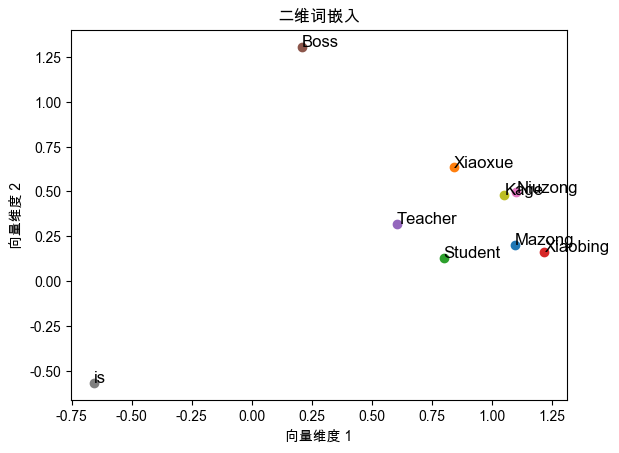

In [10]:
fig, ax = plt.subplots()
for word, idx in word_to_idx.items():
    vec = skipgram_model.input_to_hidden.weight[:, idx].detach().numpy()
    ax.scatter(vec[0], vec[1])
    ax.annotate(word, (vec[0], vec[1]), fontsize=12)
plt.title("二维词嵌入")
plt.xlabel("向量维度 1")
plt.ylabel("向量维度 2")
plt.show()

# 7. 生成 CBOW 数据集

In [11]:
def create_cbow_dataset(sentences, window_size=2):
    data = []
    for sentence in sentences:
        sentence = sentence.split()
        for idx, word in enumerate(sentence):
            countext_words = sentence[max(idx - window_size, 0): idx] + sentence[idx + 1: min(idx + window_size + 1, len(sentence))]
            data.append((word, countext_words))
    return data

    

In [12]:
cbow_data = create_cbow_dataset(sentences)
print(f"Cbow DataSet: {cbow_data[:3]}")

Cbow DataSet: [('Kage', ['is', 'Teacher']), ('is', ['Kage', 'Teacher']), ('Teacher', ['Kage', 'is'])]


# 8. 构建 CBOW 模型

In [13]:
import torch.nn as nn
class CBOW(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super().__init__()
        self.input_to_hidden = nn.Linear(voc_size, embedding_size, bias=False)
        self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias=False)
        
    def forward(self, X):
        embeddings = self.input_to_hidden(X)
        hidden_layer  = torch.mean(embeddings, dim=0)
        output_layer = self.hidden_to_output(hidden_layer.unsqueeze(0))
        return output_layer
    
        

In [14]:
embedding_size = 2
cbow_model = CBOW(voc_size, embedding_size)
print(f"CBOW model: {cbow_model}")

CBOW model: CBOW(
  (input_to_hidden): Linear(in_features=9, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)


# 9. 训练 CBOW 模型

In [15]:
import torch.optim as optim

learning_rate = 0.001
epochs = 1000
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cbow_model.parameters(), lr=learning_rate)
loss_values = []
for epoch in range(epochs):
    loss_sum = 0
    for target, context in cbow_data:
        X = torch.stack([one_hot_encoding(w, word_to_idx) for w in context]).float()
        y_true = torch.tensor([word_to_idx[target]], dtype=torch.long)
        y_pred = cbow_model(X)
        loss = criterion(y_pred, y_true)
        loss_sum += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch:{epoch + 1}, Loss:{loss_sum / len(skipgram_data)}")
        loss_values.append(loss_sum / len(skipgram_data))

Epoch:100, Loss:1.3046629905700684
Epoch:200, Loss:1.2931723880767823
Epoch:300, Loss:1.2803881072998047
Epoch:400, Loss:1.2653771352767944
Epoch:500, Loss:1.2470979595184326
Epoch:600, Loss:1.2243850708007813
Epoch:700, Loss:1.1960031461715699
Epoch:800, Loss:1.1608345317840576
Epoch:900, Loss:1.1182842874526977
Epoch:1000, Loss:1.0689264678955077


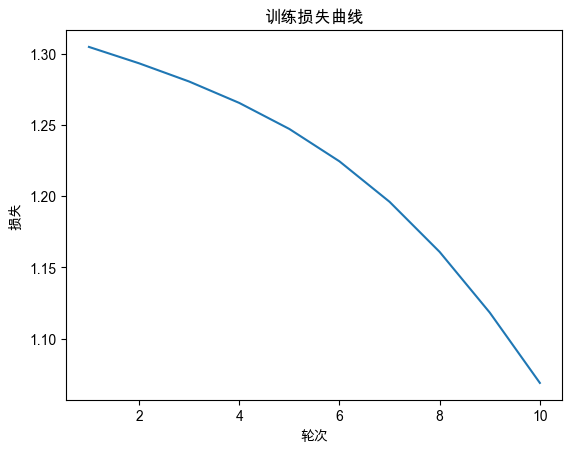

In [16]:

import matplotlib.pyplot as plt

plt.rcParams["font.family"] = ["Arial Unicode MS"]
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False

plt.plot(range(1, epochs // 100 + 1), loss_values)
plt.title("训练损失曲线")
plt.xlabel("轮次")
plt.ylabel("损失")
plt.show()

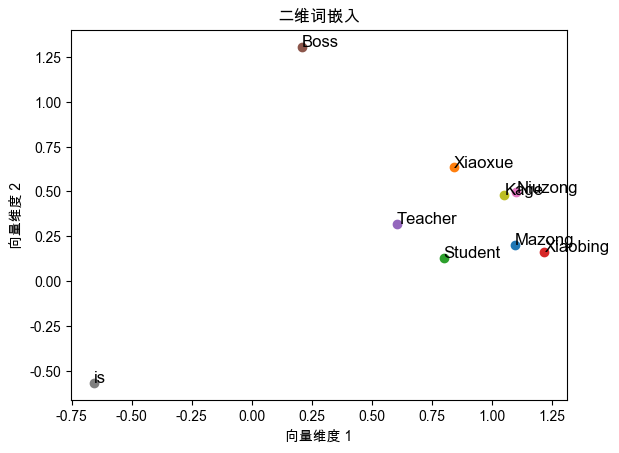

In [17]:
fig, ax = plt.subplots()
for word, idx in word_to_idx.items():
    vec = skipgram_model.input_to_hidden.weight[:, idx].detach().numpy()
    ax.scatter(vec[0], vec[1])
    ax.annotate(word, (vec[0], vec[1]), fontsize=12)
plt.title("二维词嵌入")
plt.xlabel("向量维度 1")
plt.ylabel("向量维度 2")
plt.show()